In [1]:
from pathlib import Path
import os, time
import cv2
import torch
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from tqdm import tqdm

# adjust this if your notebook runs from a different folder
BASE_DIR = Path(r"C:\Users\nshre\OneDrive\Desktop\DeepVision")  # <- change if needed
MODEL_PATH = BASE_DIR / "csrnet_model.pth"      # your checkpoint shown in screenshot
CSRNET_PY_PATH = BASE_DIR / "models" / "CSRNet.py"  # where your CSRNet class is
VIDEO_PATH = BASE_DIR / "Videos" / "video.mp4"  # put video.mp4 here (or change name)

# Make sure Python can import CSRNet.py from models
import sys
sys.path.insert(0, str(BASE_DIR / "models"))

# import your model class (adjust name if different)
from CSRNet import CSRNet


In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = CSRNet()  # if your class name differs, change here
model = model.to(device)
checkpoint = torch.load(str(MODEL_PATH), map_location=device)
# If saved state dict is wrapped in 'state_dict', adapt accordingly:
if 'state_dict' in checkpoint:
    state = checkpoint['state_dict']
else:
    state = checkpoint
# adapt keys if needed (e.g. remove 'module.' prefix)
new_state = {}
for k,v in state.items():
    name = k.replace('module.', '')  # safe fix for DataParallel prefixes
    new_state[name] = v
model.load_state_dict(new_state)
model.eval()
print("Model loaded to", device)


Model loaded to cpu


In [3]:
import torchvision.transforms as T

IMG_SIZE = (224, 224)  # change if your model uses other dims

preprocess = T.Compose([
    T.ToPILImage(),
    T.Resize(IMG_SIZE),
    T.ToTensor(),  # gives [0,1]
    T.Normalize(mean=[0.485, 0.456, 0.406],  # common ImageNet means
                std =[0.229, 0.224, 0.225])
])

def frame_to_tensor(frame_bgr):
    # frame_bgr is opencv BGR uint8
    frame_rgb = cv2.cvtColor(frame_bgr, cv2.COLOR_BGR2RGB)
    t = preprocess(frame_rgb).unsqueeze(0).to(device)  # shape [1,3,H,W]
    return t


In [5]:
def infer_frame(frame_bgr):
    """
    Input: BGR frame (numpy uint8)
    Returns: density_map (2D numpy), count (float)
    """
    with torch.no_grad():
        tensor = frame_to_tensor(frame_bgr)
        out = model(tensor)   # expected shape [1,1,h',w'] or [1,1,H,W] depending
        # Move to CPU and convert to numpy
        density = out.squeeze().cpu().numpy()
        # If model produced very small resolution map, upsample to frame size:
        density_resized = cv2.resize(density, (frame_bgr.shape[1], frame_bgr.shape[0]), interpolation=cv2.INTER_LINEAR)
        count = density_resized.sum()
    return density_resized, float(count)


In [6]:
def overlay_heatmap(frame_bgr, density, alpha=0.6, cmap=cv2.COLORMAP_JET):
    # Normalize density to 0..255
    norm = density - density.min()
    if norm.max() > 0:
        norm = (norm / norm.max() * 255).astype(np.uint8)
    else:
        norm = (norm * 0).astype(np.uint8)
    heatmap = cv2.applyColorMap(norm, cmap)
    overlay = cv2.addWeighted(frame_bgr, 1-alpha, heatmap, alpha, 0)
    return overlay


In [7]:
cap = cv2.VideoCapture(str(VIDEO_PATH))
if not cap.isOpened():
    raise RuntimeError(f"Cannot open video {VIDEO_PATH}")

threshold = 30.0  # alert threshold for people count; change as needed

while True:
    ret, frame = cap.read()
    if not ret:
        break
    density, count = infer_frame(frame)
    # annotation
    text = f"Count: {count:.1f}"
    annotated = overlay_heatmap(frame, density, alpha=0.5)
    cv2.putText(annotated, text, (10,30), cv2.FONT_HERSHEY_SIMPLEX, 1, (255,255,255), 2)
    if count > threshold:
        cv2.putText(annotated, "ALERT: OVER THRESHOLD", (10,70), cv2.FONT_HERSHEY_SIMPLEX, 0.8, (0,0,255), 2)
    cv2.imshow("DeepVision - Crowd Monitor", annotated)
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

cap.release()
cv2.destroyAllWindows()


In [8]:
cap = cv2.VideoCapture(str(VIDEO_PATH))
fps = cap.get(cv2.CAP_PROP_FPS) or 25.0
w = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
h = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))

out_path = BASE_DIR / "Videos" / "video_annotated.mp4"
fourcc = cv2.VideoWriter_fourcc(*'mp4v')
out = cv2.VideoWriter(str(out_path), fourcc, fps, (w,h))

frame_count = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
for _ in tqdm(range(frame_count)):
    ret, frame = cap.read()
    if not ret:
        break
    density, count = infer_frame(frame)
    annotated = overlay_heatmap(frame, density, alpha=0.5)
    cv2.putText(annotated, f"Count: {count:.1f}", (10,30), cv2.FONT_HERSHEY_SIMPLEX, 1, (255,255,255), 2)
    if count > threshold:
        cv2.putText(annotated, "ALERT: OVER THRESHOLD", (10,70), cv2.FONT_HERSHEY_SIMPLEX, 0.8, (0,0,255), 2)
    out.write(annotated)

cap.release()
out.release()
print("Saved annotated video to:", out_path)


100%|██████████████████████████████████████████████████████████████████████████████| 3493/3493 [24:46<00:00,  2.35it/s]

Saved annotated video to: C:\Users\nshre\OneDrive\Desktop\DeepVision\Videos\video_annotated.mp4


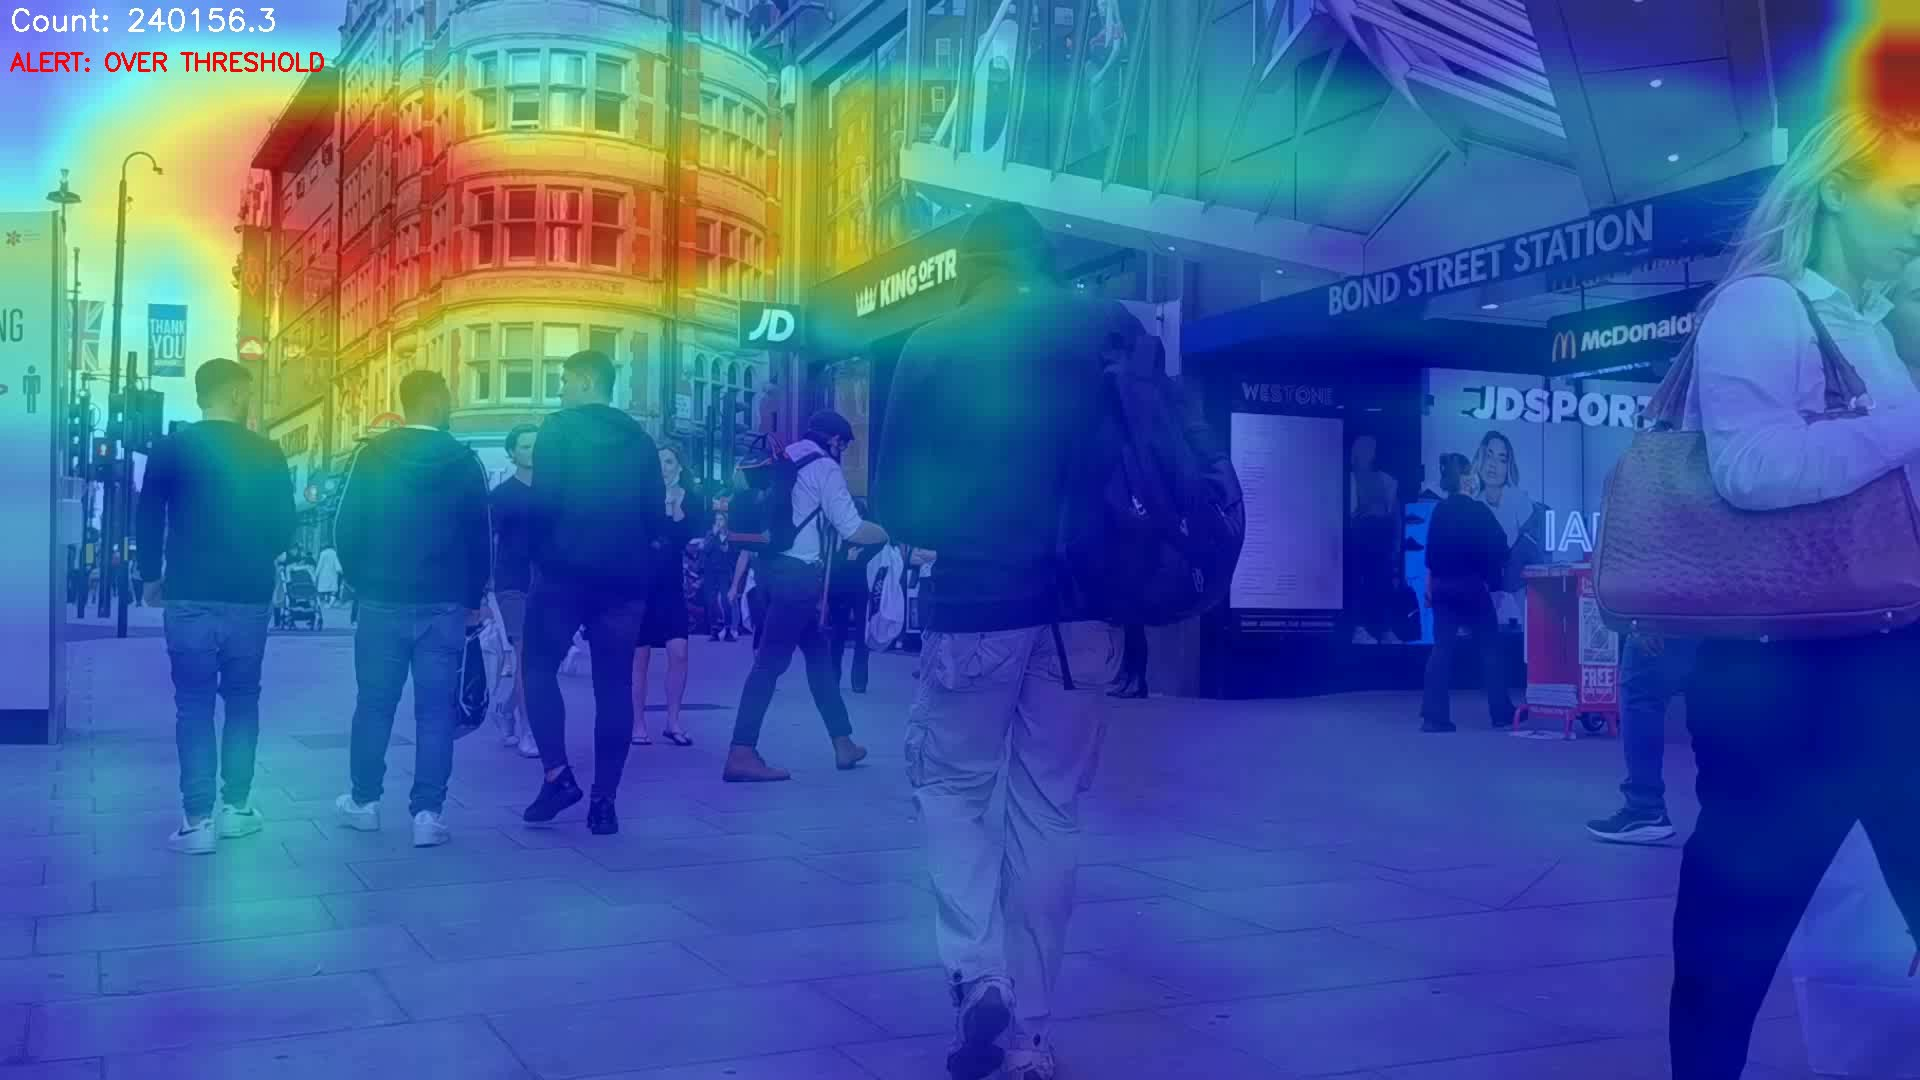

In [9]:
from IPython.display import display, Image
# show first frame of annotated video
img = cv2.imread(str(out_path))  # this may give None; use VideoCapture for a frame
cap = cv2.VideoCapture(str(out_path))
ret, frame = cap.read()
cap.release()
if ret:
    display(Image(data=cv2.imencode('.jpg', frame)[1].tobytes()))


In [11]:
import gradio as gr
import tempfile
import cv2

def process_uploaded_video(video_file, threshold=30.0):
    cap = cv2.VideoCapture(video_file.name if hasattr(video_file, 'name') else video_file)

    fps = cap.get(cv2.CAP_PROP_FPS) or 25.0
    w = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    h = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))

    # Reduce resolution for speed (VERY IMPORTANT)
    new_w, new_h = 640, 360

    tmpfile = tempfile.NamedTemporaryFile(suffix=".mp4", delete=False)
    out = cv2.VideoWriter(tmpfile.name, cv2.VideoWriter_fourcc(*'mp4v'), fps, (new_w, new_h))

    frame_id = 0
    while True:
        ret, frame = cap.read()
        if not ret:
            break

        # Skip frames to speed up (10x faster)
        if frame_id % 10 != 0:
            frame_id += 1
            continue
        frame_id += 1

        # Resize frame for CSRNet
        frame = cv2.resize(frame, (new_w, new_h))

        density, count = infer_frame(frame)

        annotated = overlay_heatmap(frame, density, alpha=0.5)
        cv2.putText(annotated, f"Count: {count:.1f}", (10, 30),
                    cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2)

        if count > threshold:
            cv2.putText(annotated, "ALERT: OVER THRESHOLD", (10, 70),
                        cv2.FONT_HERSHEY_SIMPLEX, 0.8, (0, 0, 255), 2)

        out.write(annotated)

    cap.release()
    out.release()
    return tmpfile.name


gr_interface = gr.Interface(
    fn=process_uploaded_video,
    inputs=[gr.Video(label="Upload video or use webcam"),
            gr.Slider(1, 200, 30, label="Alert threshold")],
    outputs=gr.Video(label="Annotated video"),
    title="Deep Vision Crowd Monitor",
    description="Optimized processing. Uses frame skipping & resize to avoid timeouts."
)

gr_interface.launch(share=False)


* Running on local URL:  http://127.0.0.1:7861
* To create a public link, set `share=True` in `launch()`.


Exception in callback _ProactorBasePipeTransport._call_connection_lost(None)
handle: <Handle _ProactorBasePipeTransport._call_connection_lost(None)>
Traceback (most recent call last):
  File "C:\Users\nshre\AppData\Local\Programs\Python\Python310\lib\asyncio\events.py", line 80, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\nshre\AppData\Local\Programs\Python\Python310\lib\asyncio\proactor_events.py", line 165, in _call_connection_lost
    self._sock.shutdown(socket.SHUT_RDWR)
ConnectionResetError: [WinError 10054] An existing connection was forcibly closed by the remote host
